# demo: TextGraph + LLMs

## intro

In [1]:
import pathlib
from IPython.display import display, HTML, Image
display(HTML(pathlib.Path("docs/demo/blurb.1.html").read_text(encoding = "utf-8")))

## parse a document

In [2]:
from icecream import ic
import matplotlib.pyplot as plt
import pandas as pd
import pyvis
import spacy

from textgraph import Edge, Node, Pipeline, PipelineFactory, RenderPyVis, TextGraph

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Source text -- NB: this library is intented for processing a stream of paragraphs

In [3]:
SRC_TEXT: str = """                                                                                                                      
Werner Herzog is a remarkable filmmaker and an intellectual originally from Germany, the son of Dietrich Herzog.
Although in fact Werner Herzog never really liked his father, as we all know.
After the war, Werner fled to America to become famous.
"""

In [4]:
%time

tg: TextGraph = TextGraph()

fabrica: PipelineFactory = PipelineFactory(
    dbpedia_api = PipelineFactory.DBPEDIA_API,
    #ner_model = PipelineFactory.NER_MODEL,
)

pipe: Pipeline = fabrica.build_pipeline(
    SRC_TEXT.strip(),
)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 28.1 µs


2023-12-08 11:21:34,324 - root - INFO - Initializing word embedding with word2vec.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## visualize the parse results

In [5]:
%time

spacy.displacy.render(
    pipe.ent_doc,
    style = "ent",
    jupyter = True,
)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 38.9 µs


In [6]:
%time

spacy.displacy.render(
    pipe.ent_doc,
    style = "dep",
    jupyter = True,
)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


## build a lemma graph from the document

In [7]:
%time

tg.build_graph_embeddings(
    pipe,
    debug = False,
)

ic(len(tg.nodes.values()));
ic(len(tg.edges.values()));

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


ic| len(tg.nodes.values()): 53
ic| len(tg.edges.values()): 57


## infer relations

In [8]:
%time

inferred_edges: list = tg.infer_relations(
    pipe,
    debug = False,
)

inferred_edges

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 26.9 µs


[Edge(src_node=0, dst_node=10, kind=<RelEnum.INF: 2>, rel='opennre:country_of_citizenship', prob=0.9116277694702148, count=1),
 Edge(src_node=15, dst_node=0, kind=<RelEnum.INF: 2>, rel='mrebel:child', prob=1.0, count=1),
 Edge(src_node=25, dst_node=0, kind=<RelEnum.INF: 2>, rel='mrebel:child', prob=1.0, count=1),
 Edge(src_node=40, dst_node=35, kind=<RelEnum.INF: 2>, rel='mrebel:significant_event', prob=1.0, count=1)]

## extract ranked entities

In [9]:
%time

tg.calc_phrase_ranks()

CPU times: user 39 µs, sys: 2 µs, total: 41 µs
Wall time: 42 µs


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


show the resulting entities extracted from the document

In [10]:
df: pd.DataFrame = tg.get_phrases_as_df()
df

,node_id,text,pos,label,count,weight
0,0,Werner Herzog,PROPN,http://dbpedia.org/resource/Werner_Herzog,2,0.067093
1,10,Germany,PROPN,http://dbpedia.org/resource/Germany,1,0.065849
2,15,Dietrich Herzog,PROPN,http://dbpedia.org/resource/Marlene_Dietrich,1,0.064747
3,40,America,PROPN,dbo:Country,1,0.064747
4,20,fact,NOUN,None,1,0.062568
5,35,war,NOUN,None,1,0.062568
6,37,Werner,PROPN,dbo:Person,1,0.062568
7,4,filmmaker,NOUN,None,1,0.061494
8,25,father,NOUN,None,1,0.061320
9,45,a remarkable filmmaker,noun_chunk,None,1,0.061320


## visualize the lemma graph

In [11]:
render: RenderPyVis = RenderPyVis(
    tg.nodes,
    tg.edges,
    tg.lemma_graph,
)

pv_graph: pyvis.network.Network = render.build_lemma_graph(
    debug = False,
)

set the layout parameters

In [12]:
pv_graph.force_atlas_2based(
    gravity = -38,
    central_gravity = 0.01,
    spring_length = 231,
    spring_strength = 0.7,
    damping = 0.8,
    overlap = 0,
)

pv_graph.show_buttons(filter_ = [ "physics" ])
pv_graph.toggle_physics(True)

In [13]:
pv_graph.prep_notebook()
pv_graph.show("vis.html")

vis.html


## generate a word cloud

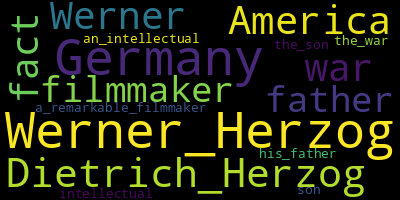

In [14]:
wordcloud = render.generate_wordcloud()
display(wordcloud.to_image())

## cluster communities in the lemma graph

In the tutorial
<a href="https://towardsdatascience.com/how-to-convert-any-text-into-a-graph-of-concepts-110844f22a1a" target="_blank">"How to Convert Any Text Into a Graph of Concepts"</a>, 
Rahul Nayak uses the
<a href="https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm"><em>girvan-newman</em></a>
algorithm to split the graph into communities, then clusters on those communities.
His approach works well for unsupervised clustering of key phrases which have been extracted from many documents.
In contrast, Nayak was working with entities extracted from "chunks" of text, not with a text graph.

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 10.3 µs


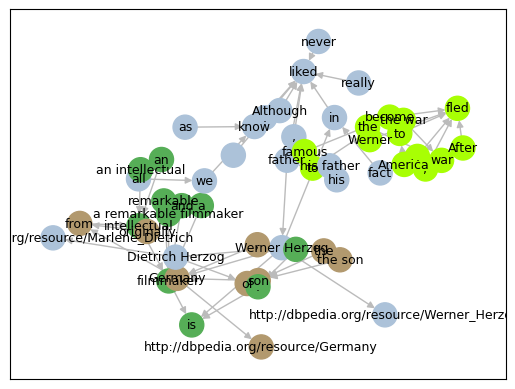

In [17]:
%time

render.draw_communities();

## outro

_\[ more parts are in progress, getting added to this demo \]_